In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy import create_engine # database connection
import sqlalchemy
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#from skmultilearn.adapt import mlknn
#from skmultilearn.problem_transform import ClassifierChain
#from skmultilearn.problem_transform import BinaryRelevance
#from skmultilearn.problem_transform import LabelPowerset
#from sklearn.naive_bayes import GaussianNB
from datetime import datetime
print('Done importing all')

Done importing all


<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [0]:
#Creating db file from csv
start = datetime.now()
disk_engine = create_engine('sqlite:///train.db')

start = dt.datetime.now()
chunksize = 100000
j = 0
index_start = 1
for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
    df.index += index_start
    j+=1
    print('{} rows'.format(j*chunksize))
    df.to_sql('train_data_of_stackoverflow', disk_engine, if_exists='append')
    index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)


100000 rows
Time taken to run this cell : 0:00:16.814435
200000 rows
Time taken to run this cell : 0:00:24.448987
300000 rows
Time taken to run this cell : 0:00:32.435646
400000 rows
Time taken to run this cell : 0:00:40.369646
500000 rows
Time taken to run this cell : 0:00:48.488472
600000 rows
Time taken to run this cell : 0:00:56.467731
700000 rows
Time taken to run this cell : 0:01:04.549541
800000 rows
Time taken to run this cell : 0:01:12.471692
900000 rows
Time taken to run this cell : 0:01:20.393455
1000000 rows
Time taken to run this cell : 0:01:28.205321
1100000 rows
Time taken to run this cell : 0:01:35.980612
1200000 rows
Time taken to run this cell : 0:01:43.631223
1300000 rows
Time taken to run this cell : 0:01:51.895985
1400000 rows
Time taken to run this cell : 0:01:59.021229
1500000 rows
Time taken to run this cell : 0:02:06.206323
1600000 rows
Time taken to run this cell : 0:02:13.053242
1700000 rows
Time taken to run this cell : 0:02:19.806309
1800000 rows
Time taken

<h3> 3.1.2 Counting the number of rows </h3>

In [0]:
start = datetime.now()

#*************** Now we have a sqlite database, every time when we have to access it, just use the 'connect' command**************

con = sqlite3.connect('train.db')
num_rows = pd.read_sql_query("""SELECT count(*) FROM train_data_of_stackoverflow""", con)
#Always remember to close the database


print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
con.close()
print("Time taken to count the number of rows :", datetime.now() - start)

Number of rows in the database : 
 36205176
Time taken to count the number of rows : 0:00:07.908222


<h3>3.1.3 Checking for duplicates </h3>

In [0]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
# if os.path.isfile('train.db'):
start = datetime.now()
con = sqlite3.connect('train.db')
df_no_dup = pd.read_sql('SELECT Title, Body, Tags, COUNT(*) as Count_duplicate_questions FROM train_data_of_stackoverflow GROUP BY Title, Body, Tags', con)
con.close()
print("Time taken to run this cell :", datetime.now() - start)

DatabaseError: Execution failed on sql 'SELECT Title, Body, Tags, COUNT(*) as Count_duplicate_questions FROM train_data_of_stackoverflow GROUP BY Title, Body, Tags': database or disk is full

In [0]:
df_no_dup.head()
# we can observe that there are duplicates

In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], 
      "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")


# From the 6 million  ,1.8 million are duplicates 

In [0]:
# number of times each question appeared in our database
df_no_dup.Count_duplicate_questions.value_counts()



# only 6 questions that are appear 5 times
# questions that appear 1 times are -> 2.6 millions  .

In [0]:
df=df_no_dup
df.shape

In [0]:
sd=[]
start = datetime.now()
for i in range(df_no_dup.shape[0]):
    f=df_no_dup["Tags"][i]# no of characters==0 
    if f==None:# when no tag given just remove that datapoint
        df_no_dup=df_no_dup.drop(i,axis=0)     # remove this datapoint
    else:
        d=len(df_no_dup["Tags"][i].split(" "))
        sd.append(d)
        
print(datetime.now()-start)

In [0]:
df_no_dup.shape

In [0]:
df_no_dup["Tag_Count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

In [0]:
# distribution of number of tags per question
df_no_dup.Tag_Count.value_counts()

<h3> Save the Non_duplicate questions in a new database </h3>

In [0]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)
    
    
    
#***********************************************train_no_dup.db is the new database **************************************

In [0]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
#if os.path.isfile('train_no_dup.db'):
start = datetime.now()
con = sqlite3.connect('train_no_dup.db')
tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
con.close()

    # Let's now drop unwanted column.
tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
tag_data.head()
print(" The Time taken to run this cell is :", datetime.now() - start)
# else:
#     print("Please download the train.db file from drive or run the above cells to genarate train.db file")

In [0]:
tag_data.head()
#no_dup.head()

<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [0]:
#****************************************First we have to count (A tag appear how many times)  or  frequency of tags.
# this can be done by countvectorizer that can give us Tag_name : Frequency
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])
# we have  42048 total  unique tags! 

In [0]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

<h3> 3.2.3 Number of times a tag appeared </h3>

In [0]:
#    THIS IS THE REPRESENTATION OF THE DATAPOINTS WITH THEIR DIMENSIONS       (SPARCE MATRIX)

'''         TAG1    TAG2     TAG3     .   ..  ..    TAG42048
DP1      1          0               1                            0
DP2      0          0                1                            1
DP3       0         0                0                            1
.
.
DP4206307   0                   1                           1



for calculating how many times a single tag appeared, we have to count the number of one's in each column
'''



# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.


'''Each row in the array is one of your original documents (strings), each column is a feature (word),
and the element is the count for that particular word and document.
You can see that if you sum each column you'll get the correct number'''
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [0]:
#************************************Saving this dictionary  of tagsto csv files **********************************************

if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:#   parameter is 'w' this means we are writing the file in the harddisk
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()



# We are saving each and every thing to database or file, so that if our computer crashes we can start from their-> where we left   

In [0]:
# **************************Sort the tags in DESC order, so that we can find the most frequent tags*******************************



tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

In [0]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [0]:
# first 10k tags

plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])#  :25 is the step sizes

<h2>Observations:</h2>
 -  Some Tags appear zero times,but its not much clear how many tags appear zero times, we have to zoom the plot.

In [0]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])         # these are the step sizes

In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])



# some tags are very huge in number  , some tags are very less in number.

<h2>Observations:</h2>
-  Some Tags appear large number of  times and some tags are appear very few times, so we can say micro average f1 is good matric for

   measuring performance.

In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
#quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000]
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000]
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [0]:
#    THIS IS THE REPRESENTATION OF THE DATAPOINTS WITH THEIR DIMENSIONS       (SPARCE MATRIX)

'''         TAG1    TAG2     TAG3     .   ..  ..    TAG42048
DP1      1          0               1                            0
DP2      0          0                1                            1
DP3       0         0                0                            1
.
.
DP4206307   0                   1                           1



for calculating in one questions how many tags apear, just sum  the numer of ones in the single row.
'''

#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()

#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

In [0]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h1> 3.3 Cleaning and preprocessing of Questions </h1>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [0]:
#******************************************Some functions for databases*****************************************
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

    
    
#***********************************************Create a databse with the empty table*****************************
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'     # old database which has all the duplicates rows
write_db = 'Processed.db'        # new database which i make in this it has one table questions_preprocessed
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 100000;")

        
        
  #****************************We get the 100000 datapoints from the  train_no_dup.db database
        
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")  # rows are empty by the way
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)



#****************************Previously we created this table, now we checking if its empty or not, if not emtpy delete al the rows*************************


Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:02:13.422156


In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

__ we create a new data base to store the sampled and preprocessed questions __

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader: # reading one row

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    
    
    
    
    #*************************   We are inseting the updated preprocessed data to the new table   'QuestionsProcessed'   ********************
 
    
    writer.execute("insert into QuestionsProcessed(question,code,tags,   words_pre,   words_post,     is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1175
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:05:20.314822


In [0]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('c program dump entir hklm registri tree consol tri write simpl consol app dump content hklm consol output look someth like much luck research help would great appreci',)
----------------------------------------------------------------------------------------------------
('android gridview column make ui like net gridview column product name textview product quantiti spinner price textview delet button button delet row question best way control android sdk ui new android think gridview good alreadi follow http www mkyong com android android gridview exampl tri use column spinner show text show littl spinner gridview',)
----------------------------------------------------------------------------------------------------
('import databas magento want import tecdoc databas magento without success tecdoc msql format export csv xml problem import product keep schema databas thank',)
--------------------------------------------------------------------------------

In [0]:
#****************************From the Processed.db database select the table 'QuestionsProcessed'*************************
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,user unabl access site connect vpn one user un...,networking vpn routing
1,c program dump entir hklm registri tree consol...,c# registry
2,android gridview column make ui like net gridv...,android gridview
3,import databas magento want import tecdoc data...,database magento import
4,exampl libpcap libnet want captur ip packag on...,linux libpcap libnet


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 99999
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [0]:
multilabel_y.shape# we have the total 18585 labels or tags.

(99999, 18511)

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]# Frequency of the particular tag             count the columns in the binary vectorizer or bag of words
    #print(len(t))
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)# sort based on the decending order of tags values (value is number of times it appear)
    #print(sorted_tags_i[:n])
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]# questions with  the tags(that get in second step) or frequent tags
    #print('***********************************************************************')
    #print(multilabel_yn)
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)# tags output that i discussed
    x= multilabel_yn.sum(axis=1)#  how many tags a single quesition has !
    #print(x)
    return ((np.count_nonzero(x==0)))# that questions we not able to explain with the labels

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

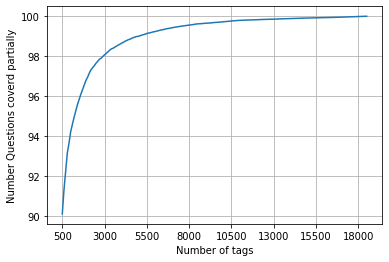

with  5500 tags we are covering  99.138 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")

plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)
print(multilabel_yx.shape)
preprocessed_data.shape

number of questions that are not covered : 862 out of  99999
(99999, 5500)


(99999, 2)

In [0]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18511
number of tags taken : 5500 ( 29.71206309761763 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [0]:
# If we given with the time, we will do teh time split. because tags are changing with the time,, may be first asp.1 versoin we had, now today new version
# launched asp.2   . so time based splitting will work here,



total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)
print(x_train.shape)
print(x_test.shape)
y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

(79999, 2)
(20000, 2)


In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (79999, 5500)
Number of data points in test data : (20000, 5500)


<h2>4.3 Featurizing data </h2>

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=50000, smooth_idf=True, norm="l2", \
                              sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:03.359503


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79999, 50000) Y : (79999, 5500)
Dimensions of test data X: (20000, 50000) Y: (20000, 5500)


In [0]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

"\nfrom skmultilearn.adapt import MLkNN\nclassifier = MLkNN(k=21)\n\n# train\nclassifier.fit(x_train_multilabel, y_train)\n\n# predict\npredictions = classifier.predict(x_test_multilabel)\nprint(accuracy_score(y_test,predictions))\nprint(metrics.f1_score(y_test, predictions, average = 'macro'))\nprint(metrics.f1_score(y_test, predictions, average = 'micro'))\nprint(metrics.hamming_loss(y_test,predictions))\n\n"

<h2> 4.5 Modeling with less data points (0.1M data points) and more weight to title and 500 tags only. </h2>

In [0]:
# Now we'll repeat all the code from the previous sections 
# procedure
#1. Take less datapoints
#2. remove the questions and give the high weitage to the title, by just repeating it 3 times.  Also with this we can reduce the dimensions.
#3.If we see logically think, users have to write the title so much attractive or Title have to cover the overall view of our error, so it can be useful.


sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweightw.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweightw.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train limit 100000;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1232
Avg. length of questions(Title+Body) after processing: 441
Percent of questions containing code: 57
Time taken to run this cell : 0:07:51.700574


In [0]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Saving Preprocessed data to a Database __

In [0]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweightw.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.shape

(99999, 2)

In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 99999
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [0]:
vectorizer = CountVectorizer(binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

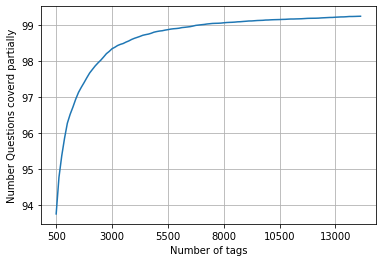

with  5500 tags we are covering  98.986 % of questions
with  500 tags we are covering  93.743 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 6257 out of  99999


In [0]:
preprocessed_data.shape[0]

99999

In [0]:
# If we given with the time, we will do teh time split. because tags are changing with the time,, may be first asp.1 versoin we had, now today new version
# launched asp.2   . so time based splitting will work here,


total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)


x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)
print(x_train.shape)
print(x_test.shape)
y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

(79999, 2)
(20000, 2)


In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (79999, 500)
Number of data points in test data : (20000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=10000, smooth_idf=True, norm="l2", sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:16.136466


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79999, 10000) Y : (79999, 500)
Dimensions of test data X: (20000, 10000) Y: (20000, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [0]:
import warnings
warnings.filterwarnings("ignore")
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1937
Hamming loss  0.0035708
Micro-average quality numbers
Precision: 0.7346, Recall: 0.3800, F1-measure: 0.5009
Macro-average quality numbers
Precision: 0.5558, Recall: 0.2813, F1-measure: 0.3510
              precision    recall  f1-score   support

           0       0.80      0.47      0.59      1805
           1       0.86      0.53      0.65      1186
           2       0.87      0.55      0.68       484
           3       0.82      0.46      0.59      1323
           4       0.87      0.60      0.71       739
           5       0.87      0.48      0.62      1023
           6       0.77      0.39      0.52      1421
           7       0.95      0.62      0.75      1450
           8       0.98      0.82      0.89      1368
           9       0.68      0.45      0.54       914
          10       0.80      0.41      0.55       186
          11       0.77      0.49      0.60       553
          12       0.78      0.40      0.53       644
          13       0.52      0.19

In [0]:
# For saving the weights or results after run applying model
#joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

<h3> 4.5.2 Featurizing data with BOW vectorizer </h3>

In [0]:
start = datetime.now()
vectorizer =  CountVectorizer(min_df=0.00009, max_features=10000, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:01.153712


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (79999, 10000) Y : (79999, 500)
Dimensions of test data X: (20000, 10000) Y: (20000, 500)


<h1>Hyperparameter tuning:</h1>

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
#from sklearn.grid_search import GridSearchCV"
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

from sklearn.model_selection import learning_curve, GridSearchCV

In [0]:
alpha =[10**-5,10**-4,10**-3,10**-2,10**-1,5,10]
perf_metric = []
for i in tqdm(alpha):
    
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42))
    clf.fit(x_train_multilabel, y_train)
    predictions = clf.predict (x_test_multilabel)
    perf_metric.append(f1_score(y_test, predictions, average='micro'))
    
#print("Time taken to run this cell :", datetime.now() - start)

100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [3:24:36<00:00, 1753.72s/it]


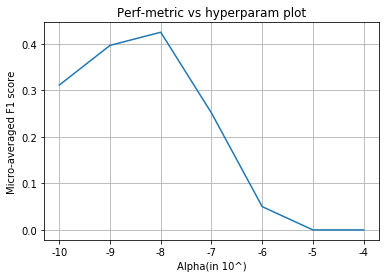

In [0]:
# plot the perf metric for each hyperparam(alpha)
fig, ax = plt.subplots()
ax.plot(perf_metric)
xlabel = list(range(-11, -3))
ax.set_xticklabels(xlabel)
plt.title("Perf-metric vs hyperparam plot")
plt.xlabel("Alpha(in 10^)")
plt.ylabel("Micro-averaged F1 score")
plt.grid()
plt.show()

<h1>Training the model with best hyperparameter</h1>

In [0]:
start = datetime.now()
# fetching the best alpha
best_alpha = alpha[np.argmax(perf_metric)]
print('Best hyperparam(alpha) : ',best_alpha)

# train the LR model with the best alpha
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_alpha, penalty='l1',  random_state=42), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

# print the various performance metrices
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss :",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("\nMicro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("\nMacro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\n")
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Best hyperparam(alpha) :  0.001
Accuracy : 0.1366
Hamming loss : 0.0044873

Micro-average quality numbers -
Precision: 0.5368, Recall: 0.3521, F1-measure: 0.4253

Macro-average quality numbers -
Precision: 0.3906, Recall: 0.2561, F1-measure: 0.2861


              precision    recall  f1-score   support

           0       0.77      0.44      0.56      1805
           1       0.83      0.47      0.60      1186
           2       0.74      0.56      0.64       484
           3       0.81      0.43      0.56      1323
           4       0.86      0.59      0.70       739
           5       0.88      0.47      0.62      1023
           6       0.67      0.41      0.51      1421
           7       0.84      0.64      0.73      1450
           8       0.92      0.57      0.71      1368
           9       0.55      0.41      0.47       914
          10       0.59      0.46      0.52       186
          11       0.73      0.50      0.59       553
          12       0.73      0.39      0.51   

<h1>Task 3: Apply OneVsRestClassifier with Linear-SVM </a>  </h1>
    <h3>      Hyperparameter Tuning </h3>

In [0]:
from tqdm import tqdm
start = datetime.now()
alpha = [10 ** x for x in range(-10, -3, 2)]
perf_metric = []
for i in tqdm(alpha):
    clf = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=i, penalty='l1', random_state=42), n_jobs=-1)
    clf.fit(x_train_multilabel, y_train)
    predictions = clf.predict (x_test_multilabel)
    # append the micro-f1 score for the particular alpha trained classifier
    perf_metric.append(f1_score(y_test, predictions, average='micro'))
print("Time taken to run this cell :", datetime.now() - start)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [29:51<00:00, 447.80s/it]


Time taken to run this cell : 0:29:51.230015


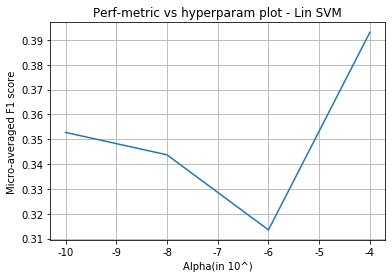

In [0]:
# plot the perf metric for each hyperparam(alpha)
fig, ax = plt.subplots()
ax.plot(perf_metric)
xlabel = list(range(-11, -3))
ax.set_xticklabels(xlabel)
plt.title("Perf-metric vs hyperparam plot - Lin SVM")
plt.xlabel("Alpha(in 10^)")
plt.ylabel("Micro-averaged F1 score")
plt.grid()
plt.show()

In [0]:
start = datetime.now()
# fetching the best alpha
best_alpha = alpha[np.argmax(perf_metric)]
print('Best hyperparam(alpha) : ',best_alpha)

# train the Lin SVM model with the best alpha
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1',  random_state=42), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

# print the various performance metrices
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss :",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("\nMicro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("\nMacro-average quality numbers -")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\n")
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Best hyperparam(alpha) :  0.0001
Accuracy : 0.0877
Hamming loss : 0.006592

Micro-average quality numbers -
Precision: 0.3473, Recall: 0.4527, F1-measure: 0.3931

Macro-average quality numbers -
Precision: 0.2390, Recall: 0.3426, F1-measure: 0.2656


              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1805
           1       0.64      0.59      0.62      1186
           2       0.52      0.70      0.60       484
           3       0.60      0.51      0.55      1323
           4       0.56      0.65      0.60       739
           5       0.65      0.50      0.56      1023
           6       0.54      0.47      0.50      1421
           7       0.75      0.72      0.74      1450
           8       0.83      0.80      0.82      1368
           9       0.50      0.51      0.51       914
          10       0.25      0.51      0.33       186
          11       0.57      0.53      0.54       553
          12       0.57      0.52      0.54   

In [0]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Vectorizer",                        "Model",                                                          "  Micro Averaged F1 Score")
tb.add_row(["                tf-idf",                   "Logistic Regression with OVR classifier",0.5005])
tb.add_row(["                Bow",                   "Logistic Regression with OVR classifier",     0.498])
tb.add_row(["                Bow",                    "SGD classifier(Logistic loss) with OVR classifier with parameter tuning",0.4995])
tb.add_row(["                Bow",                     "SGD classifier(Hinge loss)  with OVR classifier with parameter tuning", 0.3931])
print(tb.get_string(titles = "KNN - Observations"))

+------------------------+-------------------------------------------------------------------------+---------------------------+
|       Vectorizer       |                                  Model                                  |   Micro Averaged F1 Score |
+------------------------+-------------------------------------------------------------------------+---------------------------+
|                 tf-idf |                 Logistic Regression with OVR classifier                 |           0.5005          |
|                  Bow   |                 Logistic Regression with OVR classifier                 |           0.498           |
|                  Bow   | SGD classifier(Logistic loss) with OVR classifier with parameter tuning |           0.4995          |
|                  Bow   |  SGD classifier(Hinge loss)  with OVR classifier with parameter tuning  |           0.3931          |
+------------------------+-----------------------------------------------------------------------

# Step by Step Procedure


































- Get the Data from csv file and load into the sqlite database.
- Remove the duplicates rows and load the data in a new database.
- Analysis on tags and save the dictionary(Frequecny of each tag) into csv file.
- Text preprocessing and save the preprocessed text  in a new database.
- Now we have 42k tags, now we will reduce the unnecessary tags and use only the most frequent 5500 tags that covered 99.08% questions.
- Now we have many rows, high dimensions  with 5500 tags, even if we apply a simple logistic regression with one vs rest classifier it'll take above24 hours with my low ram.
- Now i Took a 0.1 million datapoint From Non_duplicate_Rows_table and again did all the steps -> 
 - Text Preprocessing and gave high weitage to title by repeating it 3 times.
- Took a first 500 frequent tags that cover the 90% of questions.
- Now apply a logistic regression with tfidf vectorizer.
- Now at last i applied  2 modles logistic regression and linear svm One vs rest classifier with hyperparameter tuning on BOW vectorizer.
- Compare all models




























